In [1]:
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from data_loader import CMAPSSLoader
from preprocessor import CMAPSSPreprocessor

In [2]:
loader = CMAPSSLoader()
# Load cleaned data - PREQUISITE: 02_prprocessing pipeline run
df = pd.read_csv('../data/silver/cmapss/FD001_cleaned.csv')
preprocessor = CMAPSSPreprocessor(df)

sample_id = 0
sample_engine = df['engine_id'].unique()[sample_id]
sensor = preprocessor.sensor_cols[0]

## RUL Clipping

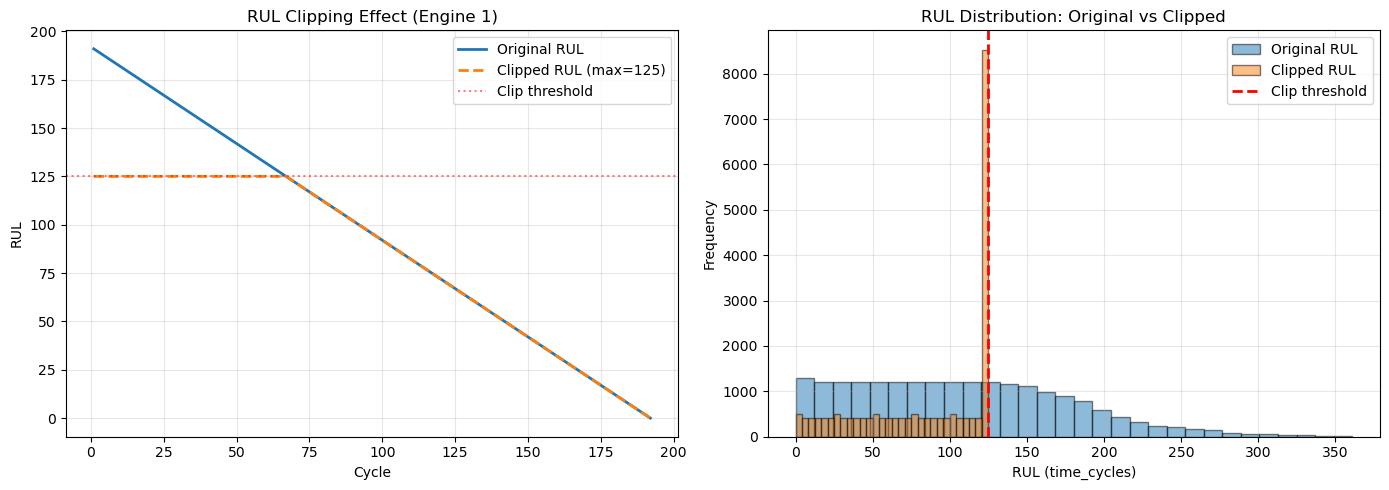


Clipping impact: 8031 cycles affected


In [3]:
# Clip RUL
RUL_CLIP = 125
df = preprocessor.clip_rul(df, clip_value=RUL_CLIP)

# Visualization: Compare original vs clipped RUL
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Comparison for one engine
sample_data = df[df['engine_id'] == sample_engine]
axes[0].plot(sample_data['time_cycles'], sample_data['RUL'], label='Original RUL', linewidth=2)
axes[0].plot(sample_data['time_cycles'], sample_data['RUL_clipped'], label=f'Clipped RUL (max={RUL_CLIP})', 
             linewidth=2, linestyle='--')
axes[0].axhline(y=RUL_CLIP, color='red', linestyle=':', alpha=0.5, label='Clip threshold')
axes[0].set_xlabel('Cycle')
axes[0].set_ylabel('RUL')
axes[0].set_title(f'RUL Clipping Effect (Engine {sample_engine})')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Distribution comparison
axes[1].hist(df['RUL'], bins=30, alpha=0.5, label='Original RUL', edgecolor='black')
axes[1].hist(df['RUL_clipped'], bins=30, alpha=0.5, label='Clipped RUL', edgecolor='black')
axes[1].axvline(x=RUL_CLIP, color='red', linestyle='--', linewidth=2, label='Clip threshold')
axes[1].set_xlabel('RUL (time_cycles)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('RUL Distribution: Original vs Clipped')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nClipping impact: {(df['RUL'] != df['RUL_clipped']).sum()} cycles affected")

## Rolling Features

Generating rolling features for windows: [5, 10, 20]
Added 156 rolling features


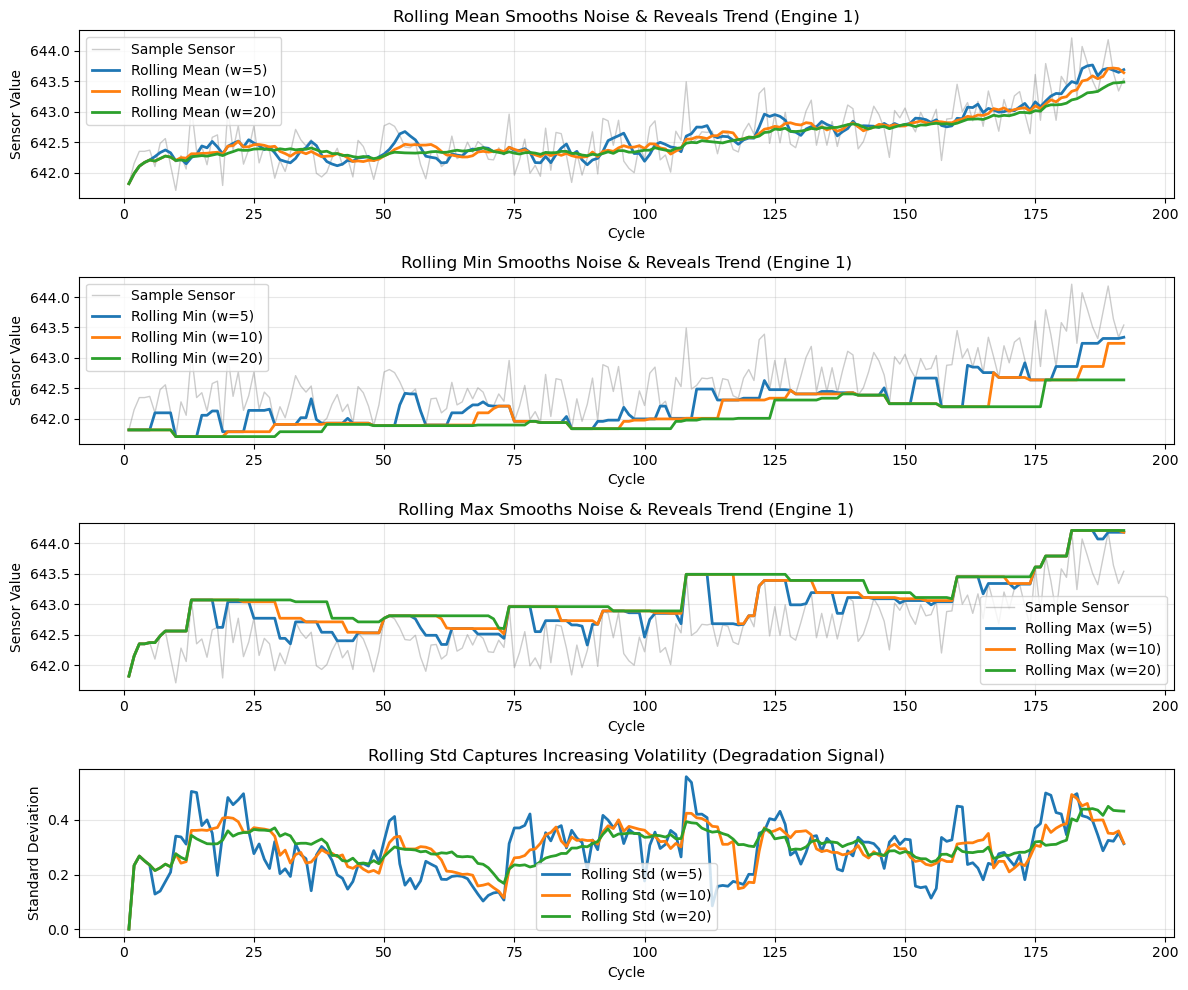

In [4]:
WINDOWS = [5, 10, 20]

df = preprocessor.add_rolling_features(df, windows=WINDOWS)

sample_data = df[df['engine_id'] == sample_engine]

fig, axes = plt.subplots(4, 1, figsize=(12, 10))

# Plot 1: Raw vs Rolling Mean
axes[0].plot(sample_data['time_cycles'], sample_data[sensor], label='Sample Sensor', 
             alpha=0.4, linewidth=1, color='gray')
for window in WINDOWS:
    axes[0].plot(sample_data['time_cycles'], sample_data[f'{sensor}_rolling_mean_{window}'], 
                 label=f'Rolling Mean (w={window})', linewidth=2)
axes[0].set_xlabel('Cycle')
axes[0].set_ylabel('Sensor Value')
axes[0].set_title(f'Rolling Mean Smooths Noise & Reveals Trend (Engine {sample_engine})')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Raw vs Rolling Min
axes[1].plot(sample_data['time_cycles'], sample_data[sensor], label='Sample Sensor', 
             alpha=0.4, linewidth=1, color='gray')
for window in WINDOWS:
    axes[1].plot(sample_data['time_cycles'], sample_data[f'{sensor}_rolling_min_{window}'], 
                 label=f'Rolling Min (w={window})', linewidth=2)
axes[1].set_xlabel('Cycle')
axes[1].set_ylabel('Sensor Value')
axes[1].set_title(f'Rolling Min Smooths Noise & Reveals Trend (Engine {sample_engine})')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: Raw vs Rolling Max
axes[2].plot(sample_data['time_cycles'], sample_data[sensor], label='Sample Sensor', 
             alpha=0.4, linewidth=1, color='gray')
for window in WINDOWS:
    axes[2].plot(sample_data['time_cycles'], sample_data[f'{sensor}_rolling_max_{window}'], 
                 label=f'Rolling Max (w={window})', linewidth=2)
axes[2].set_xlabel('Cycle')
axes[2].set_ylabel('Sensor Value')
axes[2].set_title(f'Rolling Max Smooths Noise & Reveals Trend (Engine {sample_engine})')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

# Plot 4: Rolling Std (volatility)
for window in WINDOWS:
    axes[3].plot(sample_data['time_cycles'], sample_data[f'{sensor}_rolling_std_{window}'], 
                 label=f'Rolling Std (w={window})', linewidth=2)
axes[3].set_xlabel('Cycle')
axes[3].set_ylabel('Standard Deviation')
axes[3].set_title('Rolling Std Captures Increasing Volatility (Degradation Signal)')
axes[3].legend()
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Lag Features

Generating lag features for lags: [5, 15]
Added 26 lag features


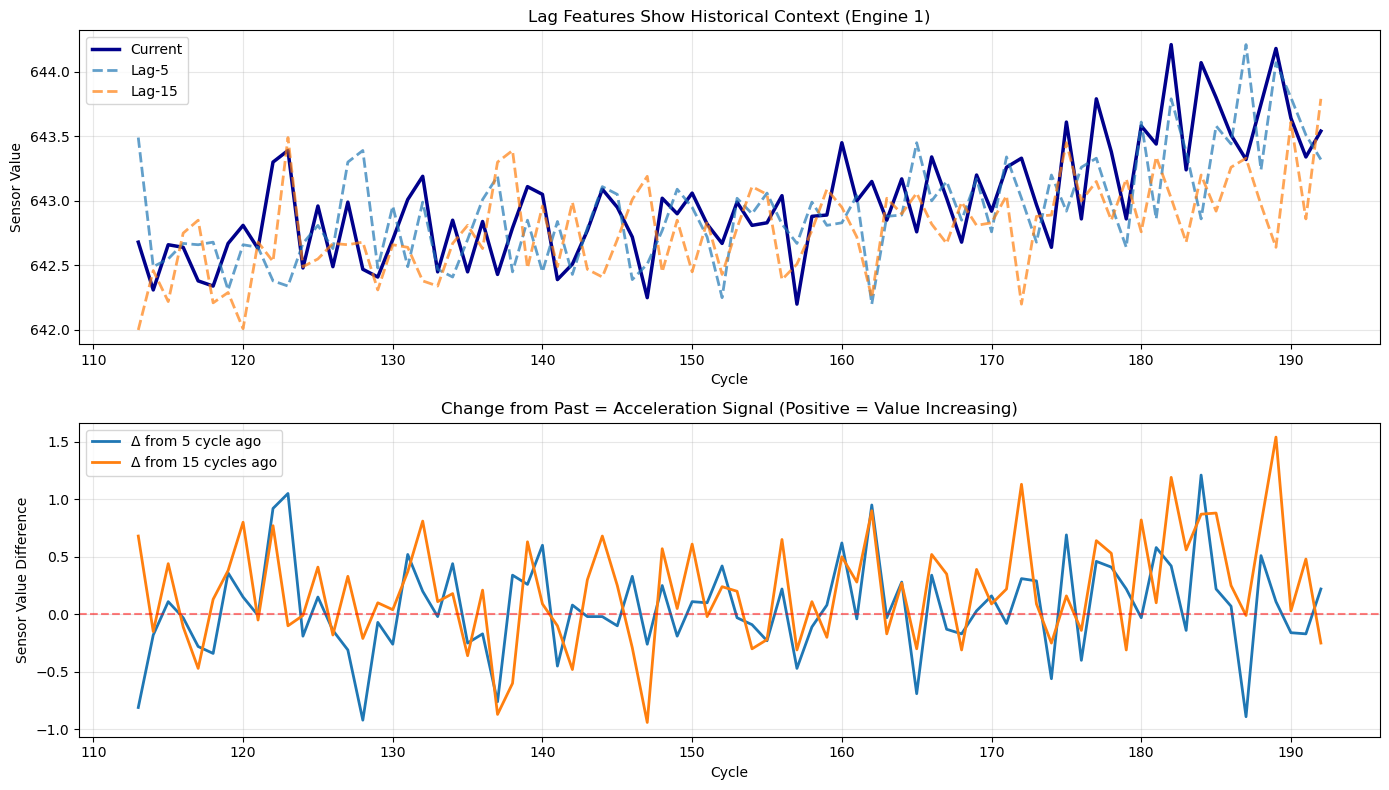

In [5]:
# Lag features
LAGS = [5, 15]

df = preprocessor.add_lag_features(df, lags=LAGS)

# Visualization: Current vs Lagged values
sample_data = df[df['engine_id'] == sample_engine].iloc[-80:] # last 80 cycles

fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Plot 1: Raw + Lag values
axes[0].plot(sample_data['time_cycles'], sample_data[sensor], label='Current', linewidth=2.5, color='darkblue')
for lag in LAGS:
    axes[0].plot(sample_data['time_cycles'], sample_data[f'{sensor}_lag_{lag}'], 
                 label=f'Lag-{lag}', linewidth=2, alpha=0.7, linestyle='--')
axes[0].set_xlabel('Cycle')
axes[0].set_ylabel('Sensor Value')
axes[0].set_title(f'Lag Features Show Historical Context (Engine {sample_engine})')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Gap between current and lag (acceleration indicator)
axes[1].plot(sample_data['time_cycles'], sample_data[sensor] - sample_data[f'{sensor}_lag_5'], 
             label='Δ from 5 cycle ago', linewidth=2)
axes[1].plot(sample_data['time_cycles'], sample_data[sensor] - sample_data[f'{sensor}_lag_15'], 
             label='Δ from 15 cycles ago', linewidth=2)
axes[1].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[1].set_xlabel('Cycle')
axes[1].set_ylabel('Sensor Value Difference')
axes[1].set_title('Change from Past = Acceleration Signal (Positive = Value Increasing)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Trend Features

Generating trend features with window=10
Added 26 trend features


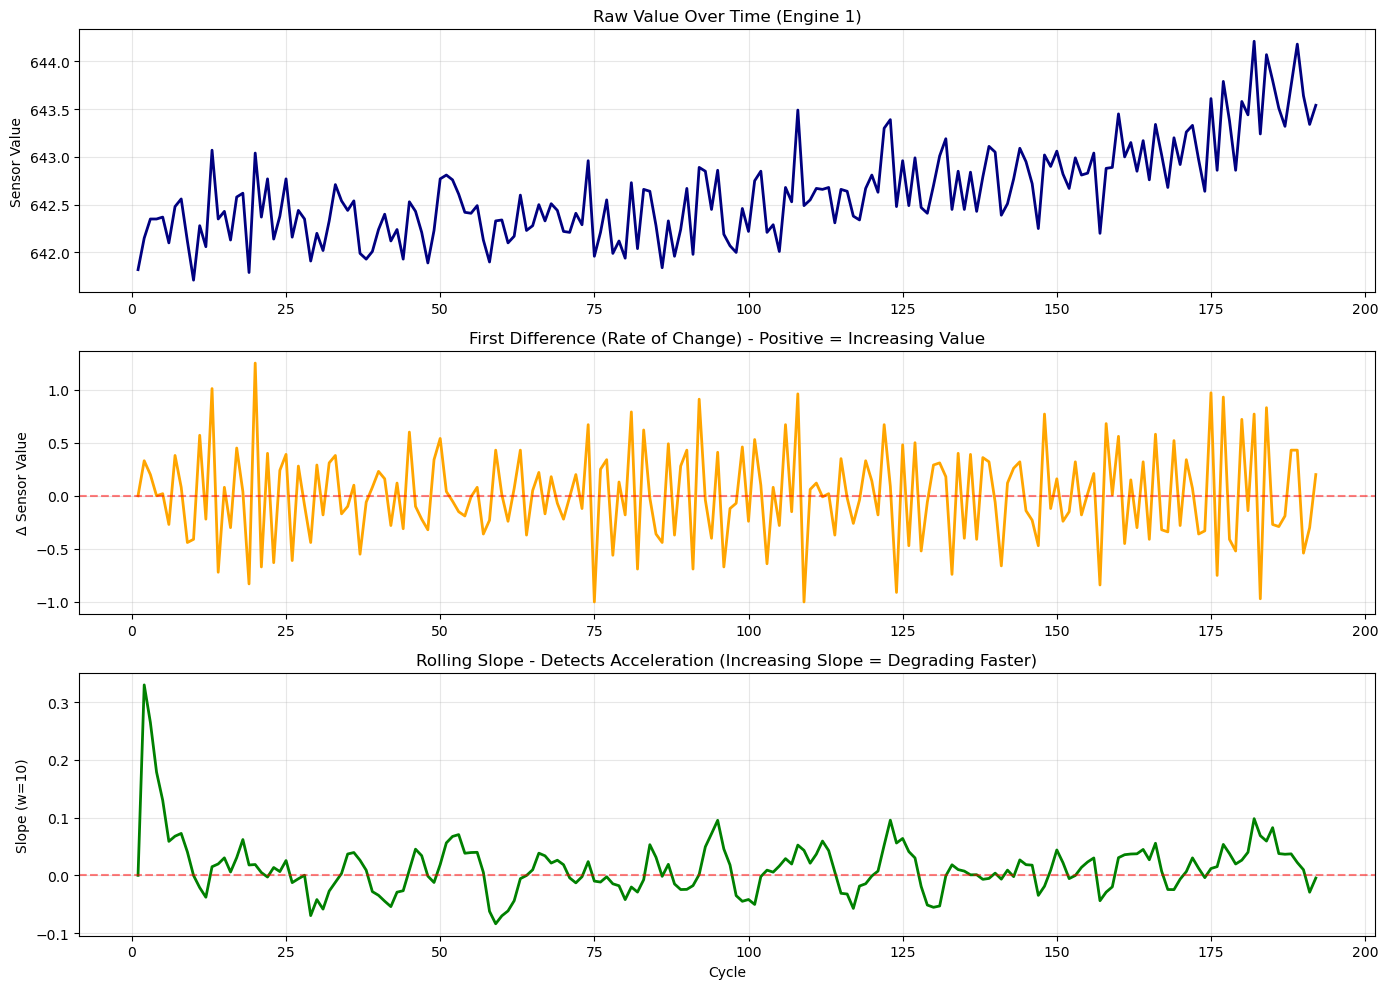

In [6]:
# Trend features
SLOPE_WINDOW = 10

df = preprocessor.add_trend_features(df, window=SLOPE_WINDOW)

# Visualization: Trend analysis
sample_data = df[df['engine_id'] == sample_engine]

fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# Plot 1: Raw sensor value
axes[0].plot(sample_data['time_cycles'], sample_data[sensor], linewidth=2, color='navy')
axes[0].set_ylabel('Sensor Value')
axes[0].set_title(f'Raw Value Over Time (Engine {sample_engine})')
axes[0].grid(True, alpha=0.3)

# Plot 2: First difference (cycle-to-cycle change)
axes[1].plot(sample_data['time_cycles'], sample_data[f'{sensor}_diff'], linewidth=2, color='orange')
axes[1].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[1].set_ylabel('Δ Sensor Value')
axes[1].set_title('First Difference (Rate of Change) - Positive = Increasing Value')
axes[1].grid(True, alpha=0.3)

# Plot 3: Rolling slope (trend direction)
axes[2].plot(sample_data['time_cycles'], sample_data[f'{sensor}_slope_{SLOPE_WINDOW}'], linewidth=2, color='green')
axes[2].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[2].set_xlabel('Cycle')
axes[2].set_ylabel(f'Slope (w={SLOPE_WINDOW})')
axes[2].set_title('Rolling Slope - Detects Acceleration (Increasing Slope = Degrading Faster)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Exponentially Weighted Moving Average

Generating EWMA features for spans: [5, 10, 20]
Added 39 EWMA features


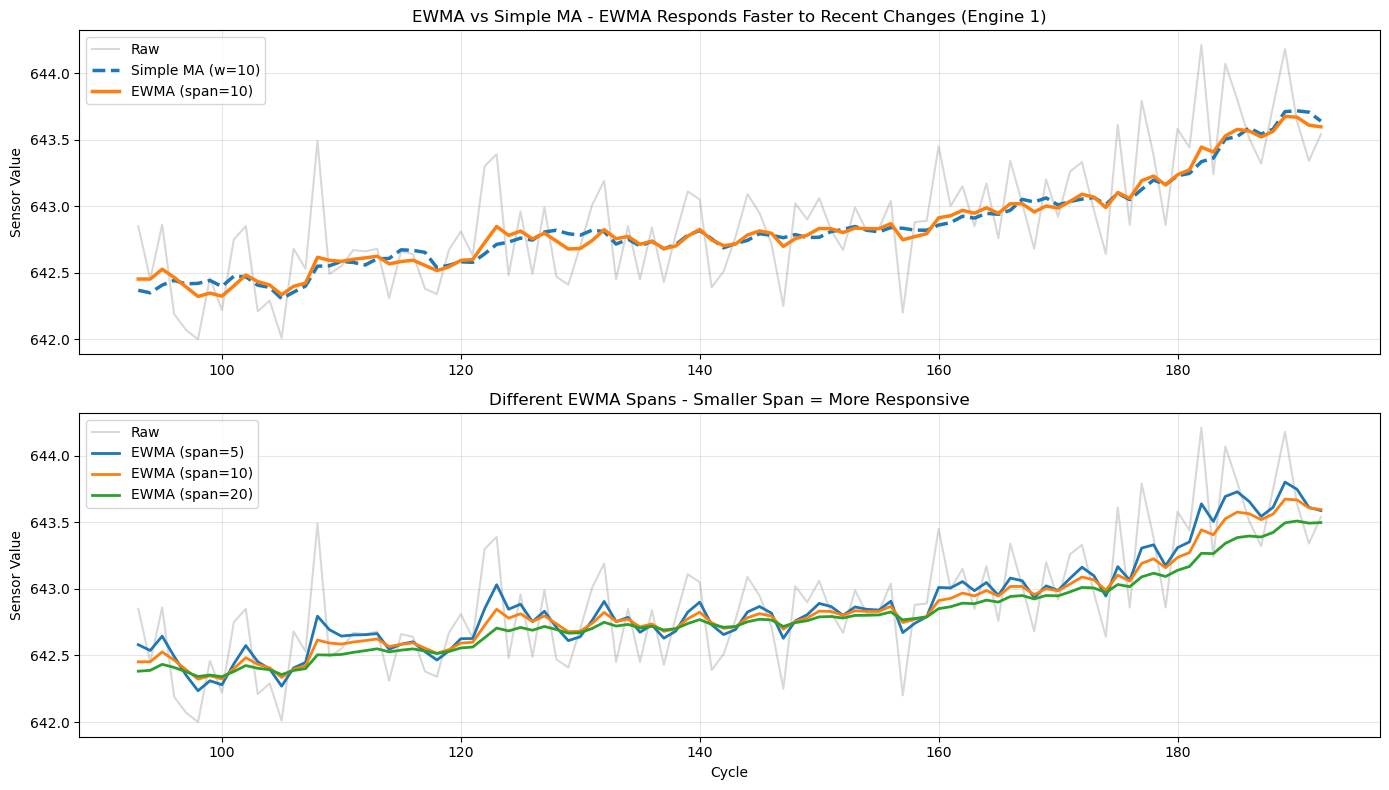

In [7]:
# EWMA features
EWMA_SPANS = [5, 10, 20]

df = preprocessor.add_ewma_features(df, spans=EWMA_SPANS)

# Visualization: EWMA vs Simple MA
sample_data = df[df['engine_id'] == sample_engine].iloc[-100:]  # last 100 cycles

fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Plot 1: EWMA vs Rolling Mean (both span=10)
axes[0].plot(sample_data['time_cycles'], sample_data[sensor], label='Raw', alpha=0.3, color='gray')
axes[0].plot(sample_data['time_cycles'], sample_data[f'{sensor}_rolling_mean_10'], 
             label='Simple MA (w=10)', linewidth=2.5, linestyle='--')
axes[0].plot(sample_data['time_cycles'], sample_data[f'{sensor}_ewma_10'], 
             label='EWMA (span=10)', linewidth=2.5)
axes[0].set_ylabel('Sensor Value')
axes[0].set_title(f'EWMA vs Simple MA - EWMA Responds Faster to Recent Changes (Engine {sample_engine})')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Multiple EWMA spans
axes[1].plot(sample_data['time_cycles'], sample_data[sensor], label='Raw', alpha=0.3, color='gray')
for span in EWMA_SPANS:
    axes[1].plot(sample_data['time_cycles'], sample_data[f'{sensor}_ewma_{span}'], 
                 label=f'EWMA (span={span})', linewidth=2)
axes[1].set_xlabel('Cycle')
axes[1].set_ylabel('Sensor Value')
axes[1].set_title('Different EWMA Spans - Smaller Span = More Responsive')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Normalization

Normalized 260 features (fitted scaler)


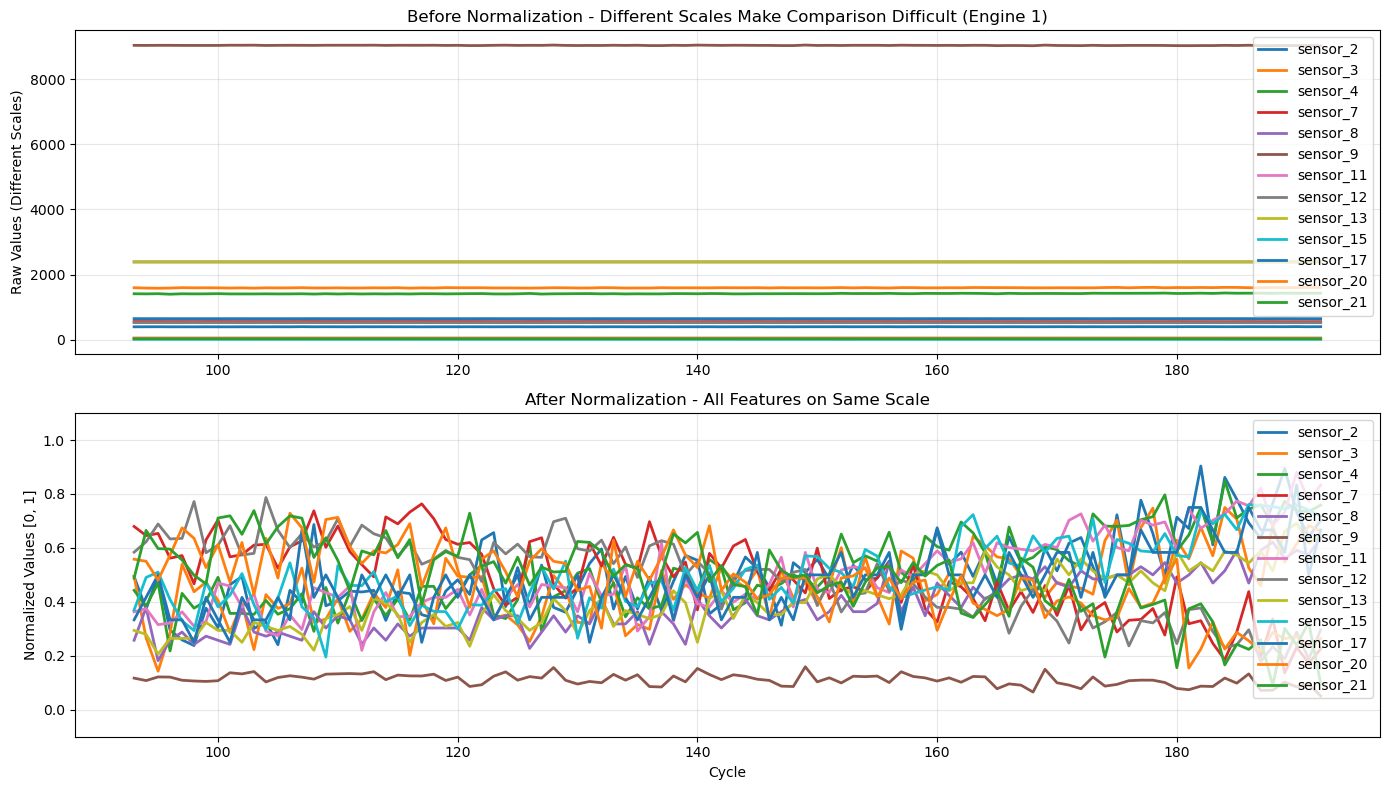


Normalization Statistics:
Before - Value range: [0.0, 1.0]
After  - Value range: [0.000, 1.000]


In [8]:
# Visualization: Before/After normalization
sample_data = df[df['engine_id'] == sample_engine].iloc[-100:]

fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Plot 1: Before normalization
for feature in preprocessor.sensor_cols:
    axes[0].plot(sample_data['time_cycles'], sample_data[feature], label=feature, linewidth=2)
axes[0].set_ylabel('Raw Values (Different Scales)')
axes[0].set_title(f'Before Normalization - Different Scales Make Comparison Difficult (Engine {sample_engine})')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Normalize features
df_normalized = preprocessor.normalize_features(df)
sample_data_norm = df_normalized[df_normalized['engine_id'] == sample_engine].iloc[-100:]

# Plot 2: After normalization
for feature in preprocessor.sensor_cols:
    axes[1].plot(sample_data_norm['time_cycles'], sample_data_norm[feature], label=feature, linewidth=2)
axes[1].set_xlabel('Cycle')
axes[1].set_ylabel('Normalized Values [0, 1]')
axes[1].set_title('After Normalization - All Features on Same Scale')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim(-0.1, 1.1)

plt.tight_layout()
plt.show()

print("\nNormalization Statistics:")
print(f"Before - Value range: [{df[sensor].min():.1f}, {df[sensor].max():.1f}]")
print(f"After  - Value range: [{df_normalized[sensor].min():.3f}, {df_normalized[sensor].max():.3f}]")

In [9]:
to_save = pd.read_csv('../data/silver/cmapss/FD001_cleaned.csv')
preprocessor = CMAPSSPreprocessor(to_save)
preprocessor.engineer_features(to_save, dataset_name='FD001')

Generating rolling features for windows: [5, 10, 20]
Added 156 rolling features
Generating lag features for lags: [1, 3, 5]
Added 39 lag features
Generating trend features with window=10
Added 26 trend features
Generating EWMA features for spans: [5, 10, 20]
Added 39 EWMA features
Normalized 273 features (fitted scaler)
Dropped 123 correlated features.

Featured data saved to /home/louis/GitHub_Repos/NASA-Turbofan-Twin/data/gold/cmapss/FD001_featured.csv


,engine_id,time_cycles,operational_setting_1,operational_setting_2,operational_setting_3,sensor_2,sensor_3,sensor_4,sensor_7,sensor_8,...,sensor_13_diff,sensor_13_slope_10,sensor_15_diff,sensor_15_slope_10,sensor_17_diff,sensor_17_slope_10,sensor_20_diff,sensor_20_slope_10,sensor_21_diff,sensor_21_slope_10
0,1,1,-0.0007,-0.0004,100.0,0.183735,0.406802,0.309757,0.726248,0.242424,...,0.351852,0.454545,0.524129,0.536952,0.500000,0.428571,0.473214,0.378378,0.503642,0.454040
1,1,2,0.0019,-0.0003,100.0,0.283133,0.453019,0.352633,0.628019,0.212121,...,0.444444,0.681818,0.575745,0.607968,0.500000,0.428571,0.419643,0.297297,0.510344,0.463520
2,1,3,-0.0043,0.0003,100.0,0.343373,0.369523,0.370527,0.710145,0.272727,...,0.277778,0.477273,0.465380,0.532044,0.333333,0.285714,0.428571,0.304054,0.387966,0.376958
3,1,4,0.0007,0.0000,100.0,0.343373,0.256159,0.331195,0.740741,0.318182,...,0.444444,0.518182,0.315988,0.440012,0.666667,0.400000,0.410714,0.298649,0.546911,0.409790
4,1,5,-0.0019,-0.0002,100.0,0.349398,0.257467,0.404625,0.668277,0.242424,...,0.277778,0.477273,0.780948,0.511663,0.583333,0.457143,0.491071,0.318919,0.548077,0.437778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,0.686747,0.587312,0.782917,0.254428,0.439394,...,0.314815,0.467493,0.287872,0.558181,0.750000,0.421645,0.785714,0.344062,0.184878,0.439722
20627,100,197,-0.0016,-0.0005,100.0,0.701807,0.729453,0.866475,0.162641,0.500000,...,0.277778,0.458127,0.600923,0.558692,0.333333,0.413853,0.303571,0.352334,0.774476,0.466236
20628,100,198,0.0004,0.0000,100.0,0.665663,0.684979,0.775321,0.175523,0.515152,...,0.388889,0.450689,0.736886,0.564298,0.750000,0.421645,0.598214,0.349058,0.174242,0.444987
20629,100,199,-0.0011,0.0003,100.0,0.608434,0.746021,0.747468,0.133655,0.530303,...,0.333333,0.448209,0.416282,0.558143,0.250000,0.419913,0.339286,0.359541,0.694056,0.442013


## Summary: Week 2.5

### What We Accomplished:

1. **RUL Clipping** - Focused model on degradation phase
2. **Rolling Features** - Smoothed noise, captured trends and volatility
3. **Lag Features** - Gave model memory and sequential context
4. **Trend Features** - Detected acceleration and rate of change
5. **EWMA Features** - Emphasized recent behavior for late-stage detection
6. **Normalization** - Ensured fair feature contribution
7. **Gold Layer** - Saved model-ready data following Medallion architecture